# Abstracting Failure-Inducing Inputs

This is a complete worked out example of the algorithm given in the paper.

We start by importing the prerequisites.

In [1]:
from enum import Enum
import copy

## Expression Example

### Predicate

First, we define a way to capture the status of an input. There can be four outcomes when an input is executed:

* Success (failure condition reproduced)
* Failed (failure condition not reproduced)
* Invalid (Did not reach failure condition -- possibly semantically invalid)
* Timeout (equivalant to Failed)

In [2]:
class PRes(str, Enum):
    success = 'SUCCESS'
    failed = 'FAILED'
    invalid = 'INVALID'
    timeout = 'TIMEOUT'

Next, we define our predicate. It is a simple test for doubled parenthesis such as `((..))`

In [3]:
import re

In [4]:
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    return PRes.failed

In [5]:
my_predicate = expr_double_paren

We also define an input.

In [6]:
expr_input =  '1 + ((2 * 3 / 4))'

In [7]:
my_input = expr_input

We verify that we can reproduce the failing condition correctly.

In [8]:
assert my_predicate(my_input) == PRes.success

In [9]:
assert my_predicate('(1+2)') == PRes.failed

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [10]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [11]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [12]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_string()` function converts a derivation tree to its original string.

In [13]:
def tree_to_string(tree, wrap=lambda ntree, depth, name, string: string, depth=0):
    name, children, *rest = tree
    if not is_nt(name):
        return name
    else:
        return wrap(tree, depth, name, ''.join([tree_to_string(c, wrap, depth-1) for c in children]))

In [14]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol='<start>', canonical=True)
parsed_expr = list(expr_parser.parse(my_input))[0]
tree_to_string(parsed_expr)

'1 + ((2 * 3 / 4))'

#### Graphical trees

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [15]:
from graphviz import Digraph

In [16]:
from IPython.display import display, Image

In [17]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [18]:
def extract_node(node, id):
    symbol, children, *annotation = node
    return symbol, children, ''.join(str(a) for a in annotation)
def node_attr(dot, nid, symbol, ann): dot.node(repr(nid), symbol)
def edge_attr(dot, start_node, stop_node): dot.edge(repr(start_node), repr(stop_node))
def graph_attr(dot): dot.attr('node', shape='plain')
def display_tree(derivation_tree):
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children, annotation) = extract_node(tree, id)
        node_attr(dot, id, symbol, annotation)
        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                edge_attr(dot, id, child_id)
                traverse_tree(dot, child, child_id)
    dot = Digraph(comment="Derivation Tree")
    graph_attr(dot)
    traverse_tree(dot, derivation_tree)
    return dot

We are now ready to display the tree structure.

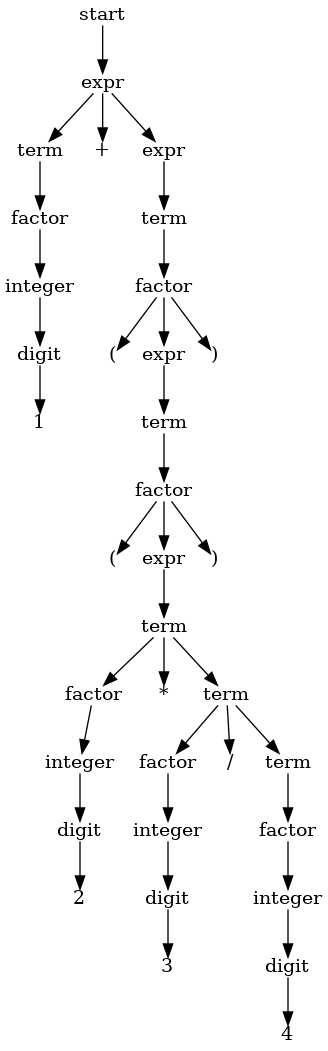

In [19]:
zoom(display_tree(parsed_expr))

## Reduction

We are now ready to define our delta debugging reduction phase. We use the **Perses** algorithm. We first have to define a way to address a specific node.

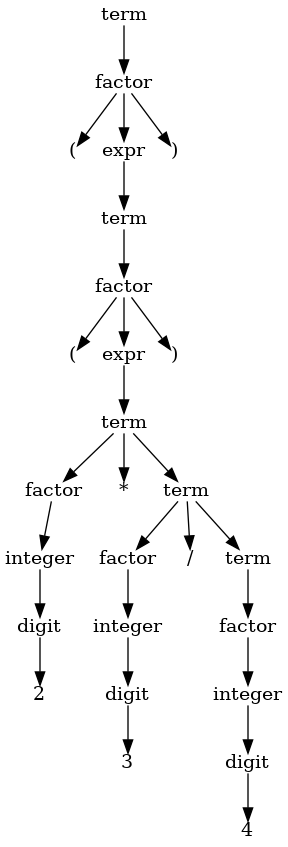

In [20]:
t = parsed_expr[1][0][1][2][1][0]
zoom(display_tree(t))

In [21]:
tree_to_string(t)

'((2 * 3 / 4))'

For the path, we simply use a list of numbers indicating the child node. For example, in the above, the path would be `[0, 2, 0]`

Given a path, `get_child()` will simply return the node at the path.

In [22]:
def get_child(tree, path):
    if not path: return tree
    cur, *path = path
    return get_child(tree[1][cur], path)

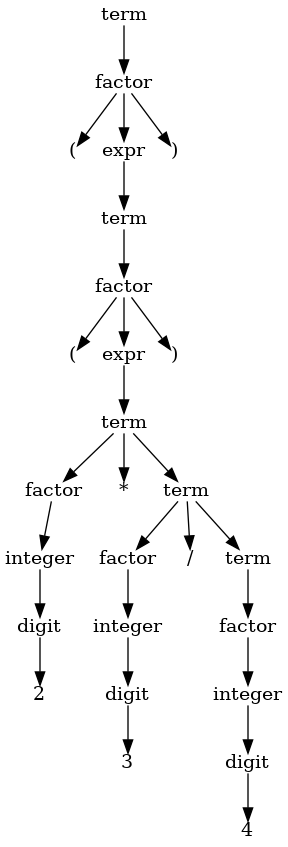

In [23]:
te = get_child(parsed_expr, [0, 2, 0])
zoom(display_tree(te))

In [24]:
tree_to_string(te)

'((2 * 3 / 4))'

We also need a way to replace one node with another. This is done by `replace_path()`.

In [25]:
def replace_path(tree, path, new_node=None):
    if new_node is None: new_node = []
    if not path: return copy.deepcopy(new_node)
    cur, *path = path
    name, children, *rest = tree
    new_children = []
    for i,c in enumerate(children):
        if i == cur:
            nc = replace_path(c, path, new_node)
        else:
            nc = c
        if nc:
            new_children.append(nc)
    return (name, new_children, *rest)

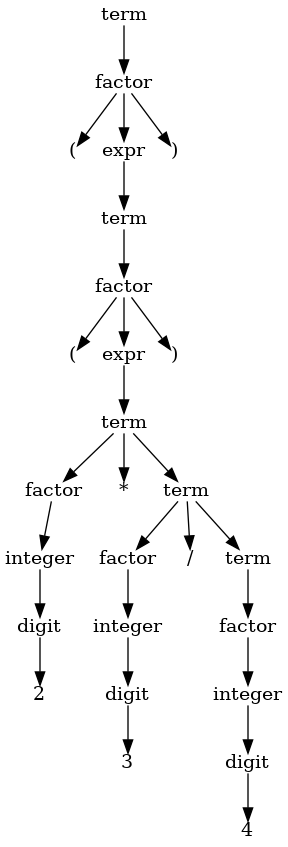

In [26]:
t = parsed_expr[1][0][1][2][1][0]
zoom(display_tree(t))

In [27]:
tree_to_string(t)

'((2 * 3 / 4))'

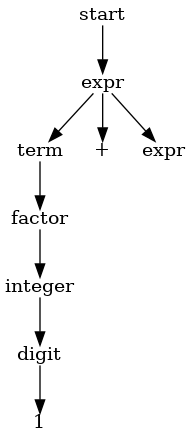

In [28]:
te = replace_path(parsed_expr, [0, 2, 0], [])
zoom(display_tree(te))

In [29]:
tree_to_string(te)

'1 + '

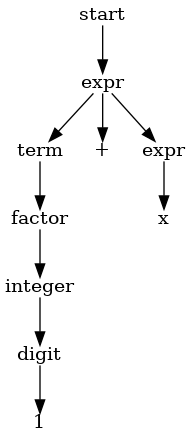

In [30]:
tn = replace_path(parsed_expr, [0, 2, 0], ('x',[]))
zoom(display_tree(tn))

In [31]:
tree_to_string(tn)

'1 + x'

### Priority queue

For perses reduction, one needs a way to count the number of leaf nodes to determine the priority of a node. This is done by `count_leaves()`

In [32]:
import heapq

In [33]:
def count_leaves(node):
    name, children, *_ = node
    if not children:
        return 1
    return sum(count_leaves(i) for i in children)

In [34]:
count_leaves(parsed_expr)

11

In [35]:
count_leaves(te)

3

We also define a helper that simply counts the internal nodes.

In [36]:
def count_nodes(node):
    name, children, *_ = node
    if not children:
        return 0
    return sum(count_nodes(i) for i in children) + 1

In [37]:
count_nodes(parsed_expr)

25

Next, we need to maintain a priority queue of the `[(tree, path)]`. The essential idea is to prioritize the items first by the number of leaves in  the full tree, then next by the number of leaves in the node pointed to by path, and finally, tie break by the insertion order (`ecount`).

In [38]:
ecount = 0

In [39]:
def add_to_pq(tup, q):
    global ecount
    dtree, F_path = tup
    stree = get_child(dtree, F_path)
    n =  count_leaves(dtree)
    m =  count_leaves(stree)
    # heap smallest first
    heapq.heappush(q, (n, m, -ecount, tup))
    ecount += 1

We define another helper function `nt_group()` that groups all nonterminals that have the same name. These are used to determine the nodes that can be used to replace one node.

In [40]:
def nt_group(tree, all_nodes=None):
    if all_nodes is None: all_nodes = {}
    name, children, *_ = tree
    if not is_nt(name): return
    all_nodes.setdefault(name, []).append(tree)
    for c in children:
        nt_group(c, all_nodes)
    return all_nodes

In [41]:
gp = nt_group(te)
for key in gp:
    print(key)
    for node in gp[key]:
        print(tree_to_string(node))

<start>
1 + 
<expr>
1 + 

<term>
1
<factor>
1
<integer>
1
<digit>
1


What are the compatible nodes? These are all the nodes that have the same nonterminal name, and is a descendent of the current node. Further, if the nonterminal allows empty node, then this is the first in the list. This is defined by `compatible_nodes()`

In [42]:
def compatible_nodes(tree, grammar):
    key, children, *_ = tree
    # Here is the first choice. Do we restrict ourselves to only children of the tree
    # or do we allow all nodes in the original tree? given in all_nodes?
    lst = nt_group(tree)
    node_lst = [(i, n) for i,n in enumerate(lst[key])]

    # insert empty if the grammar allows it as the first element
    if [] in grammar[key]: node_lst.insert(0, (-1, (key, [])))
    return node_lst

### Perses reduction

We finally define the reduction algorithm. The implementation of __Perses__ is given in `reduction()`

In [43]:
def reduction(tree, grammar, predicate):
    global KEY
    first_tuple = (tree, [])
    p_q = []
    add_to_pq(first_tuple, p_q)

    ostr = tree_to_string(tree)
    assert predicate(ostr) == PRes.success
    failed_set = {ostr: True}

    min_tree, min_tree_size = tree, count_leaves(tree)
    while p_q:
        # extract the tuple
        _n, _m, _ec, (dtree, F_path) = heapq.heappop(p_q)
        stree = get_child(dtree, F_path)
        skey, schildren = stree
        KEY = 'reduction:%s' % skey
        found = False
        # we now want to replace stree with alternate nodes.
        for i, node in compatible_nodes(stree, grammar):
            # replace with current (copy).
            ctree = replace_path(dtree, F_path, node)
            if ctree is None: continue # same node
            v = tree_to_string(ctree)
            if v in failed_set: continue
            failed_set[v] = predicate(v) # we ignore PRes.invalid results
            if failed_set[v] == PRes.success:
                found = True
                ctree_size = count_leaves(ctree)
                if ctree_size < min_tree_size: min_tree, min_tree_size = ctree, ctree_size

                if v not in failed_set:
                    print(v)
                t = (ctree, F_path)
                assert get_child(ctree, F_path) is not None
                add_to_pq(t, p_q)

        # The CHOICE here is that we explore the children if and only if we fail
        # to find a node that can replace the current
        if found: continue
        if is_token(skey): continue # do not follow children TOKEN optimization
        for i, child in enumerate(schildren):
            if not is_nt(child[0]): continue
            assert get_child(tree=dtree, path=F_path + [i]) is not None
            t = (dtree, F_path + [i])
            add_to_pq(t, p_q)
    return min_tree

Some programming languages have `tokens` which are first level lexical elements. The parser is often defined using the lexer tokens. We do not want to try to reduce tokens further. So we define a way to identify them (we have to keep in mind when we produce grammars).

In [44]:
def is_token(val):
    assert val != '<>'
    assert (val[0], val[-1]) == ('<', '>')
    if val[1].isupper(): return True
    #if val[1] == '_': return val[2].isupper() # token derived.
    return False

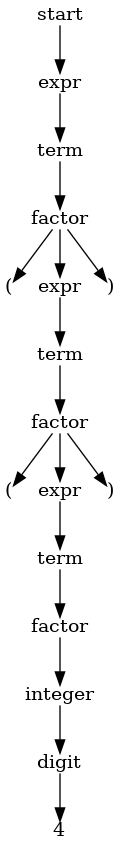

In [45]:
er = reduction(parsed_expr, EXPR_GRAMMAR, my_predicate)
zoom(display_tree(er))

In [46]:
tree_to_string(er)

'((4))'

## A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [47]:
import random

### The interface

In [48]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [49]:
COST = None

In [50]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar: return key
        if depth > max_depth:
            assert key in self.cost
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return self.gen_rule(random.choice(rules), depth+1, max_depth)

    def gen_rule(self, rule, depth, max_depth):
        return ''.join(self.gen_key(token, depth, max_depth) for token in rule)

    def fuzz(self, key='<start>', max_depth=10):
        return self.gen_key(key=key, depth=0, max_depth=max_depth)

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
        return cost

In [51]:
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
expr_fuzzer.fuzz()

'-8'

## Abstraction

We can now start to define abstraction.

### Mark the abstract nodes

Give a list of paths that were verified as abstract, we go through each, and mark them abstract in the same tree.

In [52]:
def mark_verified_path(tree, path):
    name, children = get_child(tree, path)
    new_tree = replace_path(tree, path, (name, children, {'abstract': True}))
    return new_tree

def mark_verified_abstract(tree, verified_paths):
    for path in verified_paths:
        tree = mark_verified_path(tree, path)
    return tree

A method to mark everything else as concrete.

In [53]:
def mark_concrete(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete(c) for c in children], abstract)

Next, we define a method that given a list of paths, will replace each of these nodes with random values.

In [54]:
def replace_arr_with_random_values(npath_arr, grammar, tree):
    if not npath_arr: return tree
    npath, *npath_arr = npath_arr
    node = get_child(tree, npath)
    gf = LimitFuzzer(grammar)
    e = gf.fuzz(key=node[0])
    ntree = replace_path(tree, npath, [node[0], [(e, [])]])
    assert ntree is not None
    return replace_arr_with_random_values(npath_arr, grammar, ntree)

A wrapper for the `replace_arr_with_random_values()`

In [55]:
def generate(dtree, grammar, paths):
    res = replace_arr_with_random_values([p[0] for p in paths], grammar, dtree)
    return tree_to_string(res)

### Check if we can generalize a node

We now define `can_generalize()`. This function takes a current path, the derivation tree, the grammar, predicate and a list of unverified paths the maximum number of checks (`max_checks`), and produces `max_checks` number of inputs where every node in unverified and the current node in `tval` is replaced with random values. This is then checked to see if the resulting input reproduces the failure. This way, we can verify that `tval` can be generalized even when other abstract nodes are replaced with random values.

In [56]:
MAX_CHECKS=100
MAX_LIMIT=1000
FIND_COUNTER_EXAMPLE=True
MIN_EXAMPLES=1

In [57]:
def can_generalize(tval, dtree, grammar, predicate, unverified, max_checks):
    checks = 0
    limit = 0
    abstract = True
    rstr = None
    checks = set()
    while len(checks) < max_checks:
        limit += 1
        if limit >= MAX_LIMIT:
            # giveup.
            if FIND_COUNTER_EXAMPLE:
                if len(checks) > MIN_EXAMPLES:
                    abstract = True
                else:
                    abstract = False
            else:
                abstract = False
            path, status = tval
            node = get_child(dtree, path)
            print('warn: giving up', node[0], 'after', MAX_LIMIT,
                    'and no counterexample found.'
                    'with', len(checks),
                    'valid values abstract:', abstract)
            break
        rstr = generate(dtree, grammar, [tval] + unverified)
        pres = predicate(rstr)
        if pres == PRes.failed:
            abstract = False
            break
        else:
            if pres == PRes.success:
                checks.add(rstr)
            else:
                continue
    return abstract

The `abstraction()` uses `can_generalize()` to check whether each node can be abstracted. The main job of `abstraction()` is to recurse into the child nodes when a previously abstract node is marked as concrete.

In [58]:
SKIP_IS_SPECIAL=True
SKIP_IS_CONCRETE = True

In [59]:
check_counter = 0

In [60]:
def abstraction(tval, dtree, grammar, predicate, unverified, max_checks):
    global check_counter, KEY
    path, status = tval
    node = get_child(dtree, path)
    KEY = "%s:(%s) %s" % (node[0], tree_to_string(node), status)
    if LOG:
        print(check_counter, 'check:', node[0], status)
        check_counter += 1
    key, children, *rest = node
    if not children: return []
    if not is_nt(key): return []

    if key == '<_SKIP>' and SKIP_IS_SPECIAL:
        if SKIP_IS_CONCRETE: return []
        if status == St.unchecked:
            print('abstract: unverified', node[0])
            return [(path, St.unverified)]
        else:
            print('abstract: verified', node[0])
            return [(path, St.verified)]

    abstract = can_generalize(tval, dtree, grammar, predicate, unverified, max_checks)
    if abstract:
        if status == St.unchecked:
            print('abstract: unverified', node[0])
            return [(path, St.unverified)]
        else:
            print('abstract: verified', node[0])
            return [(path, St.verified)]
    else:
        if status == St.unverified:
            print('NOT ABSTRACT:', KEY)

        if is_token(key): return []
        paths = []
        # what should we do when an unverified node is found not abstract?
        # do we look at the child nodes? It can be costly, because now we
        # are also dealing with random values in other nodes marked general.
        if status == St.unchecked or LOOK_DEEPER_IN_ISOLATED:
            for i,child in enumerate(children):
                if not is_nt(child[0]): continue
                tval = (path + [i], St.unchecked)
                p = abstraction(tval, dtree, grammar, predicate, unverified, max_checks)
                paths.extend(p)
        return paths

### Isolation

To isolate independent causes,  We first collect all nodes that can be independently generalized, and then check whether they are still generalizable even when other abstract marked nodes are replaced with random values.

In [61]:
class St(Enum):
    unchecked = 1
    unverified = -1
    verified = 0

In [62]:
gen_counter = 0

In [63]:
LOG=True

In [64]:
def isolation(tree, grammar, predicate, max_checks):
    global gen_counter
    unverified = [([], St.unchecked)]
    verified = []
    while unverified:
        v = unverified.pop(0)
        if LOG:
            node = get_child(tree, v[0])
            print(gen_counter, 'isolation:', node[0], v[1])
            gen_counter += 1
        newpaths = abstraction(v, tree, grammar, predicate, unverified, max_checks)
        print('current paths:')
        for p in newpaths:
            node = get_child(tree, p[0])
            print(">\t", p, "%s<%s>" % (node[0], repr(tree_to_string(node))))
        print()

        for p in newpaths:
            if p[1] == St.verified:
                verified.append(p)
            elif p[1] == St.unverified:
                unverified.append(p)
            else:
                assert false
    print('abstract paths:', len(verified))
    new_tree = mark_verified_abstract(tree, [p[0] for p in verified])
    # now change everything else to False
    return mark_concrete(new_tree)

### Context Sensitivity

In finding similar nodes, we have to give first preference
to the paths with maximum *amount* of common elements that can
be identified on a string in terms of character count. No
similarity analysis should be allowed on the nodes where a
previous analysis detected similarity

The essential idea here is to first find _concrete_ nodes, and
check their string representation one at a time with other concrete
nodes.

In [65]:
def e_g(abstract_a):
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [66]:
def identify_concrete_paths_to_nt(gtree, path=None):
    if path is None: path = []
    name, children, *_general = gtree
    general = e_g(_general)

    # we dont care about general non terminals
    if general and is_nt(name): return []
    # we dont care about terminals either
    if not is_nt(name): return []
    if name == '<_SKIP>': return []

    my_paths = [path]
    # for tokens we do not care about things below
    if is_token(name): return my_paths

    for i, c in enumerate(children):
        ps = identify_concrete_paths_to_nt(c, path + [i])
        my_paths.extend(ps)
    return my_paths

The `markup_paths` simply rename the context sensitive nodes with a `$` prefix. Since there can be multiple context sensitive nodes with the same nonterminal, but separate usages, we also append a number to them.

In [67]:
nsym = 0

In [68]:
def markup_paths(tkey, paths, gtree):
    global nsym
    nsym += 1
    name, string = tkey
    newname = '<$%s_%d>' % (name[1:-1], nsym)
    for p in paths:
        cname, children, gen = get_child(gtree, p)
        assert name == cname
        # now it is generalizable!
        gtree = replace_path(gtree, p, (newname, children, {'sensitive': True, 'abstract': True})) 
    return gtree

How do we verify that two keys are abstractable but context sensitive? generate random values for them, and replace it in all instances, and verify that the faults can be reproduced.

In [69]:
def are_these_similar(tkey, paths, grammar, gtree, predicate, max_checks=100):
    name, string = tkey
    if len(paths) < 2: return False
    gf = LimitFuzzer(grammar)
    nchecks = 0
    seen = set()
    global KEY
    KEY = 'similar: ' + name
    for i in range(max_checks):
        v = gf.fuzz(key=name)
        if v in seen: continue
        seen.add(v)
        # now replace it in all paths
        ctree = gtree
        for p in paths:
            ctree = replace_path(ctree, p, (name, [(v, [])]))
        res = tree_to_string(ctree)
        pr = predicate(res)
        if pr == PRes.failed:
            print(repr(v), repr(res))
            return False
        elif pr == PRes.success:
            continue
        elif pr == PRes.invalid  or pr == PRes.timeout:
            nchecks += 1

    if len(seen) <= 1: # a single
        return False

    # there has been at least one successful replacement
    return nchecks < max_checks

In [70]:
def find_similar_nodes(gtree, cpaths):
    strings = {}
    for path in cpaths:
        n = get_child(gtree, path)
        s = tree_to_string(n)
        if not len(s): continue
        key = (n[0], s)
        strings.setdefault(key, []).append(path)
    return {s:strings[s] for s in strings if len(strings[s]) > 1}

In [71]:
def identify_similarities(grammar, predicate, generalized_tree, max_checks=100):
    cpaths = identify_concrete_paths_to_nt(generalized_tree)
    similar_nodes = find_similar_nodes(generalized_tree, cpaths)

    for key in similar_nodes:
        res = are_these_similar(key, similar_nodes[key], grammar, generalized_tree, predicate, max_checks)
        if res and len(similar_nodes[key]) > 1:
            generalized_tree = markup_paths(key, similar_nodes[key], generalized_tree)
        print('Similar?', key, res)
    # from_paths_identify_similar
    # for each similar verify if they can be fuzzed together.
    return generalized_tree

Finally we need to define the string representation of the tree. This is done by `general_str()`

In [72]:
def general_str(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    v = tree_to_string(tree)
    if not v.strip(): return v
    general = e_g(general_)
    if general:
        if is_nt(name):
            if name == '<>': return v
            return name
        else:
            assert not children
            return name
    res = []
    for c in children:
        x = general_str(c)
        res.append(x)
    return ''.join(res)

### All Together

In [73]:
def get_abstraction(grammar_, my_input, predicate, max_checks=100):
    start = grammar_.get('[start]', '<start>')
    grammar = grammar_['[grammar]']
    assert start in grammar
    assert predicate(my_input) == PRes.success
    d_tree, *_ = Parser(grammar, start_symbol=start, canonical=True).parse(my_input)
    min_tree = reduction(d_tree, grammar, predicate)
    min_s = tree_to_string(min_tree)

    dd_tree_ =  isolation(min_tree, grammar, predicate, max_checks)
    dd_tree = identify_similarities(grammar, predicate, dd_tree_, max_checks)
    s = general_str(dd_tree)
    return min_s, s, dd_tree

In [74]:
min_s, s, dd_tree = get_abstraction({'[start]': '<start>', '[grammar]': EXPR_GRAMMAR}, my_input, my_predicate)

0 isolation: <start> St.unchecked
0 check: <start> St.unchecked
1 check: <expr> St.unchecked
2 check: <term> St.unchecked
3 check: <factor> St.unchecked
4 check: <expr> St.unchecked
5 check: <term> St.unchecked
6 check: <factor> St.unchecked
7 check: <expr> St.unchecked
abstract: unverified <expr>
current paths:
>	 ([0, 0, 0, 1, 0, 0, 1], <St.unverified: -1>) <expr><'4'>

1 isolation: <expr> St.unverified
8 check: <expr> St.unverified
abstract: verified <expr>
current paths:
>	 ([0, 0, 0, 1, 0, 0, 1], <St.verified: 0>) <expr><'4'>

abstract paths: 1


The extracted minimal tree:

In [75]:
min_s

'((4))'

The abstract input

In [76]:
s

'((<expr>))'

The tree

In [77]:
dd_tree

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('4', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': True}),
              (')', [], {'abstract': False})],
             {'abstract': False})],
           {'abstract': False})],
         {'abstract': False}),
        (')', [], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': False})],
 {'abstract': False})

In [78]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

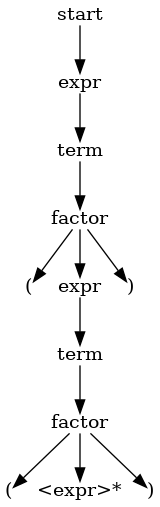

In [79]:
zoom(display_tree(till_abstract(dd_tree)))

In [80]:
assert general_str(dd_tree) == '((<expr>))'

## Lua

We now provide a fully worked out example using Lua.

Importing allprerequisites:

In [81]:
import os.path
import json
import tempfile
import subprocess
import copy

We also have a separate grammar file which was converted from the [ANTLR Lua grammar](https://github.com/antlr/grammars-v4/blob/master/lua/Lua.g4).

In [82]:
GRAMMAR_FILE='../lang/lua/grammar/lua.fbjson'

Since we have an external compiler, we also have to define how to execute it.

In [83]:
TIMEOUT=5

In [84]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

def do(command, env=None, shell=False, log=False, **args):
    result = subprocess.Popen(command,
        stdout = subprocess.PIPE,
        stderr = subprocess.STDOUT,
    )
    try:
        stdout, stderr = result.communicate(timeout=TIMEOUT)
        result.kill()
        stderr = '' if stderr is None else stderr.decode('utf-8', 'ignore')
        stdout = '' if stdout is None else stdout.decode('utf-8', 'ignore')
        return O(returncode=result.returncode, stdout=stdout, stderr=stderr)
    except subprocess.TimeoutExpired as e:
        try:
            result.kill()
        except PermissionError:
            pass
        return O(returncode=255, stdout='TIMEOUT', stderr='')

A wrapper to write the input string to a file first.

In [85]:
def I_do(prefix, cmd, src, as_string=False):
    o = None
    if as_string:
        o = do(cmd.split(' ') + [src])
    else:
        with tempfile.NamedTemporaryFile(prefix=prefix) as tmp:
            tname = tmp.name
            tmp.write(src.encode('UTF-8'))
            tmp.flush()
            o = do(cmd.split(' ') + [tname])
    return o

### The predicate

The compiler is [Lua 5.3.5](https://www.lua.org/ftp/lua-5.3.5.tar.gz) compiled and linked.

In [86]:
COMPILER='../lang/lua/compilers/lua'

The bug corresponds to the 4th bug [here](https://www.lua.org/bugs.html#5.3.5-4).

In [87]:
BUG='../lang/lua/bugs/4.lua'

In [88]:
def my_predicate(src):
    o = I_do('lua', '%s --' % COMPILER, src)
    if o.returncode == 0: return PRes.failed
    if o.returncode == -11: return PRes.success
    out = o.stdout
    if 'Segmentation fault (core dumped)' in out:
        return PRes.success
    elif 'stack traceback' in out:
        return PRes.invalid
    elif 'TIMEOUT' in out:
        return PRes.timeout
    return PRes.failed

Other helpers to load the grammar and the bug

In [89]:
def load_grammar(grammar_fn, bug_fn, pred):
    meta, tree = load_parsed_bug(bug_fn, grammar_fn)
    name = os.path.basename(bug_fn)

    return meta, tree, name

In [90]:
def load_bug(bug_fn, grammar_meta):
    with open(bug_fn) as f: bug_src = f.read()
    start = grammar_meta['[start]']
    grammar = grammar_meta['[grammar]']
    parser = Parser(grammar, start_symbol=start, canonical=True) # log=True)
    forest = parser.parse(bug_src.strip())
    tree = list(forest)[0]
    return grammar_meta, coalesce(tree)

In [91]:
def load_parsed_bug(bug_fn, grammar_fn):
    with open(grammar_fn) as f:
        grammar_meta = json.loads(f.read())
    return load_bug(bug_fn, grammar_meta)

We define a coalesce to manage the tokens.

In [92]:
def coalesce(tree):
    name, children, *rest = tree
    if not is_nt(name):
        return (name, children, *rest)
    elif is_token(name):
        v = tree_to_string(tree)
        return (name, [(v, [])], *rest)
    else:
        return (name, [coalesce(n) for n in children], *rest)

In [93]:
meta, tree, name = load_grammar(GRAMMAR_FILE, BUG, my_predicate)

In [94]:
tree_to_string(tree)

'f=load(function() end)\ninteresting={}\ninteresting[0]=string.rep("A",512)\ndebug.upvaluejoin(f,1,f,1)'

In [95]:
my_predicate(tree_to_string(tree))

<PRes.success: 'SUCCESS'>

In [96]:
list(meta.keys())

['[start]', '[grammar]']

### Reduction

In [97]:
min_tree = reduction(tree, meta['[grammar]'], my_predicate)

In [98]:
tree_to_string(tree)

'f=load(function() end)\ninteresting={}\ninteresting[0]=string.rep("A",512)\ndebug.upvaluejoin(f,1,f,1)'

### Abstraction

In [99]:
min_s, abs_s, a_mintree = get_abstraction(meta,tree_to_string(tree), my_predicate, MAX_CHECKS)

2 isolation: <chunk> St.unchecked
9 check: <chunk> St.unchecked
10 check: <block> St.unchecked
11 check: <_block_re_1> St.unchecked
12 check: <_block_STAR_0> St.unchecked
13 check: <stat> St.unchecked
14 check: <varlist> St.unchecked
15 check: <var> St.unchecked
16 check: <_var_re_51> St.unchecked
17 check: <_var_OR_48> St.unchecked
18 check: <_var_SEQ_49> St.unchecked
19 check: <_NAME_sp_> St.unchecked
20 check: <_SKIP> St.unchecked
21 check: <NAME> St.unchecked
warn: giving up <NAME> after 1000 and no counterexample found.with 1 valid values abstract: False
22 check: <_var_re_53> St.unchecked
23 check: <_var_STAR_52> St.unchecked
24 check: <_varlist_re_35> St.unchecked
25 check: <_varlist_STAR_32> St.unchecked
26 check: <_SKIP> St.unchecked
27 check: <explist> St.unchecked
28 check: <exp> St.unchecked
29 check: <prefixexp> St.unchecked
30 check: <varOrExp> St.unchecked
31 check: <var> St.unchecked
32 check: <_var_re_51> St.unchecked
33 check: <_var_OR_48> St.unchecked
34 check: <_var

220 check: <_block_Q_2> St.unchecked
221 check: <_EOF_sp_> St.unchecked
222 check: <_SKIP> St.unchecked
current paths:

abstract paths: 0
'\r (\x0c"*"--[===[]===]ornil>true--[[]]ornil//...//nil^...--\\rand(true)orfunction()end--\\r\\n^function()endandfunction()end--[[]].....--[[]]..nil/--\\nfunction()end--[[]]|...#!*\n[[]]--[=[]=]):A{--[[]]}:V\n(#!)--[[]].--\\nx:d\r--[[]](...)--\\r\\n[--\\nfunction( )--[[]]end#!]--\\r\\n[(false)--\\n]' '\r (\x0c"*"--[===[]===]ornil>true--[[]]ornil//...//nil^...--\\rand(true)orfunction()end--\\r\\n^function()endandfunction()end--[[]].....--[[]]..nil/--\\nfunction()end--[[]]|...#!*\n[[]]--[=[]=]):A{--[[]]}:V\n(#!)--[[]].--\\nx:d\r--[[]](...)--\\r\\n[--\\nfunction( )--[[]]end#!]--\\r\\n[(false)--\\n]=load(function() end)\ninteresting={}\ninteresting[0]="A"\ndebug.upvaluejoin(\r (\x0c"*"--[===[]===]ornil>true--[[]]ornil//...//nil^...--\\rand(true)orfunction()end--\\r\\n^function()endandfunction()end--[[]].....--[[]]..nil/--\\nfunction()end--[[]]|...#!*\n[[

In [100]:
min_s

'f=load(function() end)\ninteresting={}\ninteresting[0]="A"\ndebug.upvaluejoin(f,1,f,1)'

In [101]:
abs_s

'<$NAME_1>=load(function() end)\n<$NAME_2>={}\n<$NAME_2>[0]="A"\ndebug.upvaluejoin(<$NAME_1>,1,<$NAME_1>,1)'

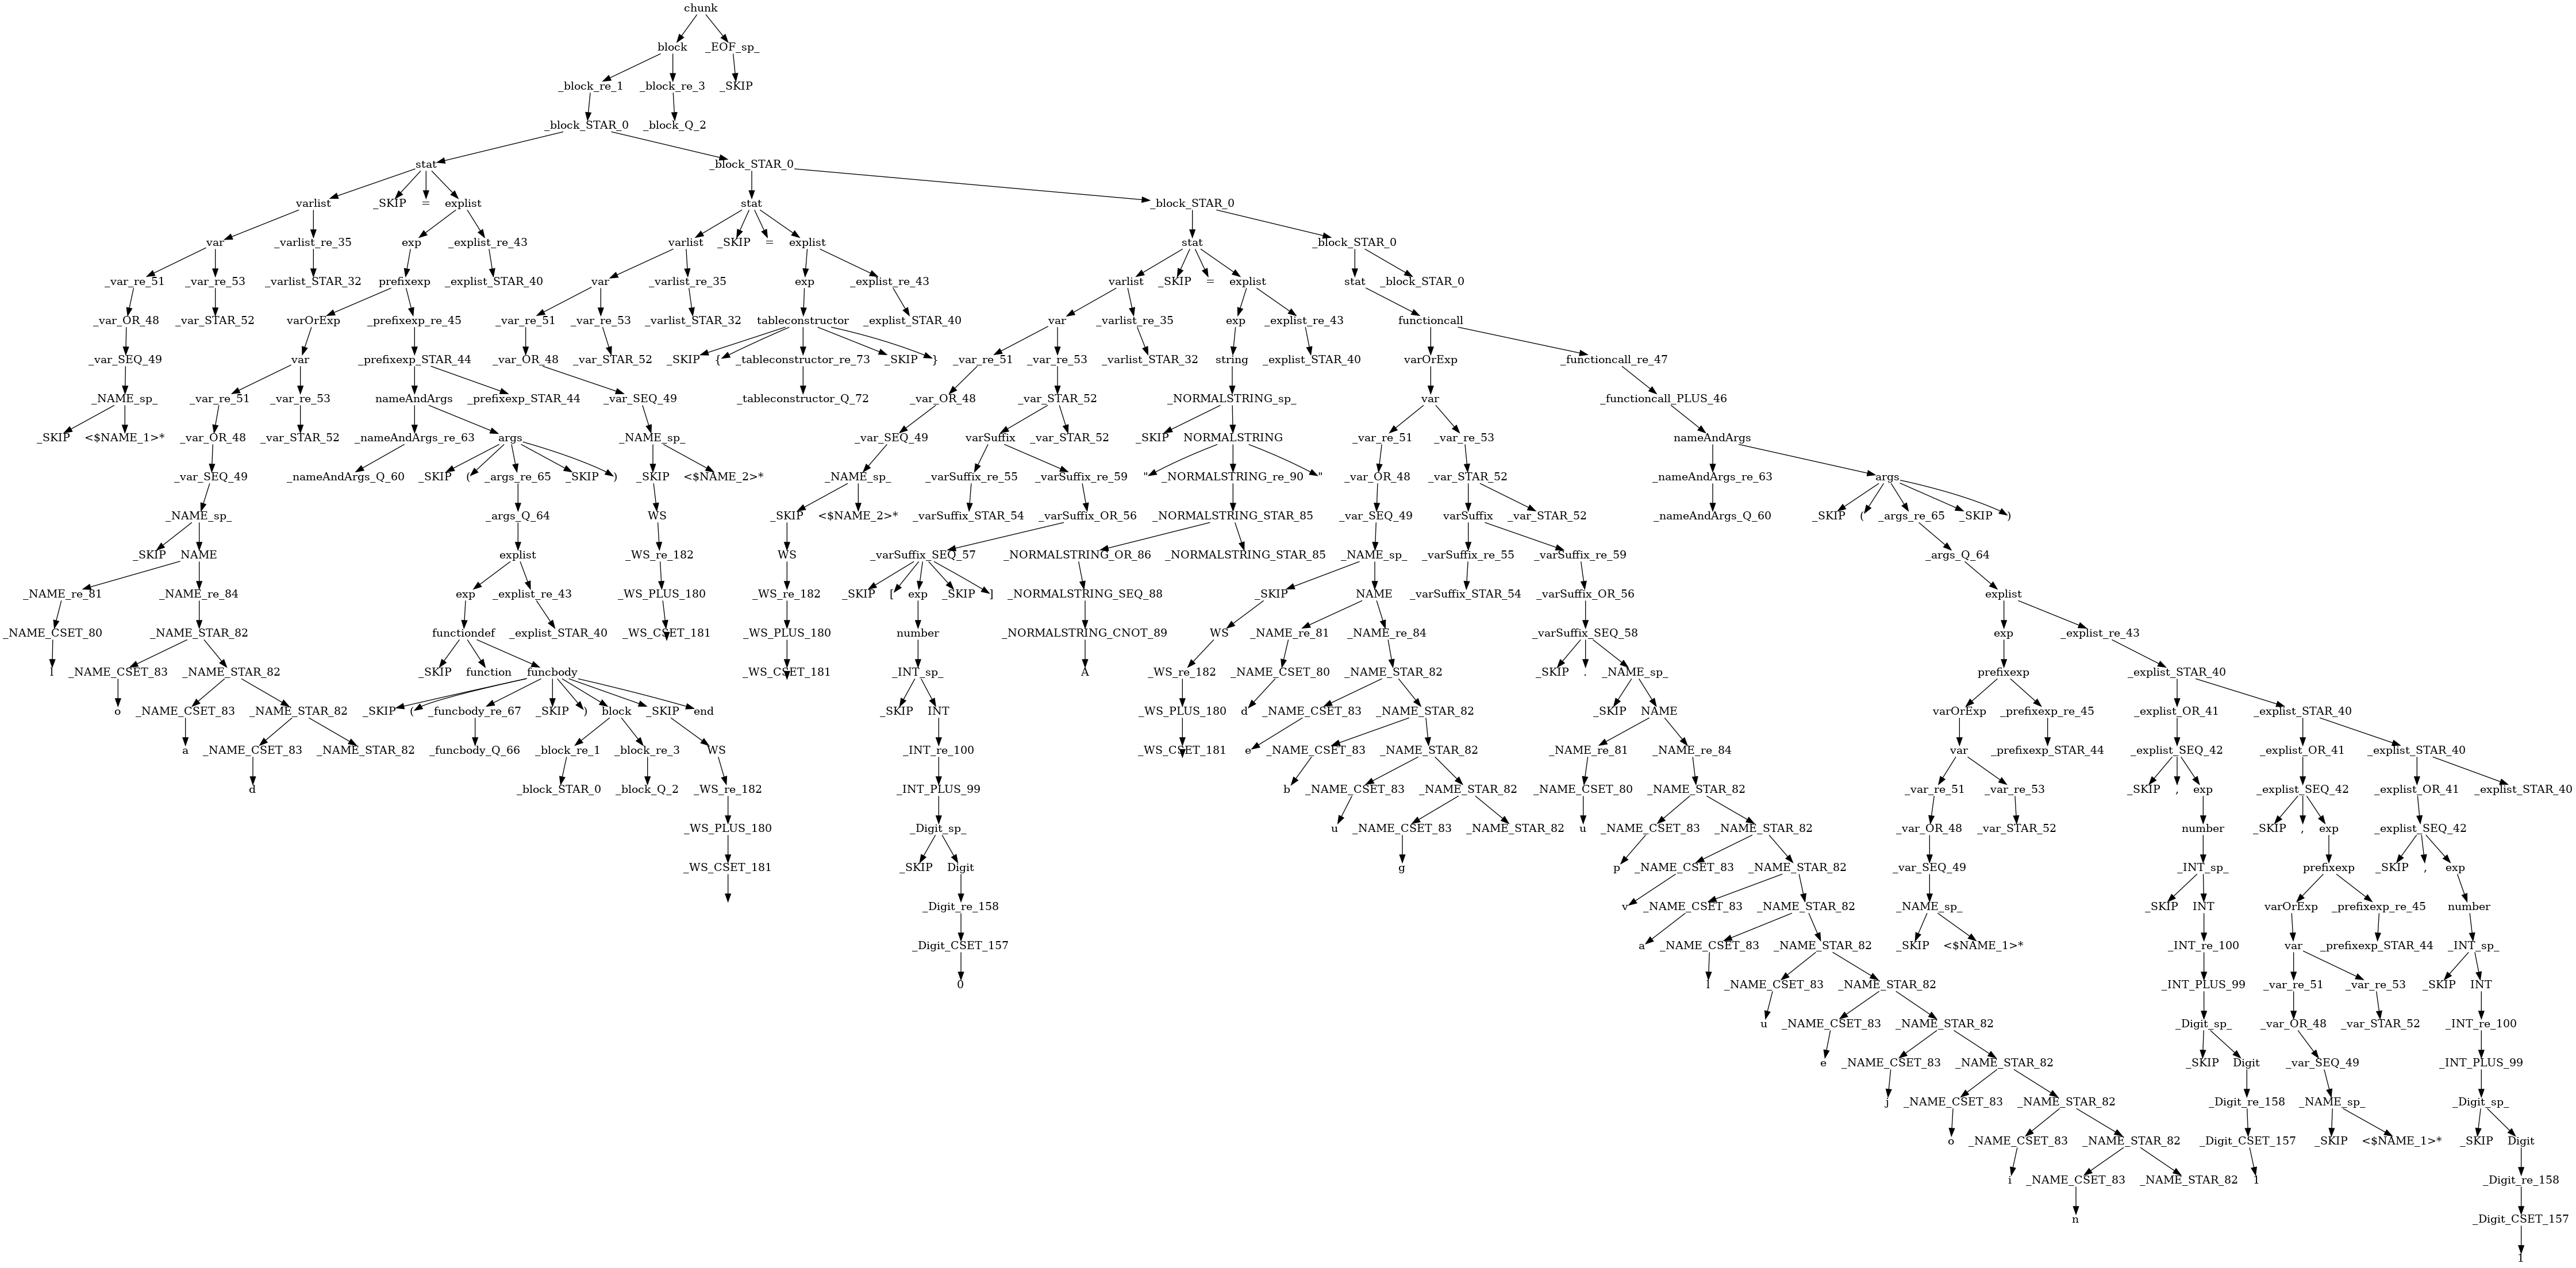

In [102]:
zoom(display_tree(till_abstract(a_mintree)))